In [244]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import os # Corretto da 'oss'
from tqdm import tqdm
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity


colors_for_freq_mapping_reversed = [
    (0.0, '#00008B'),  # DarkBlue (Basse frequenze)
    (0.2, '#1E90FF'),  # DodgerBlue
    (0.4, '#ADFF2F'),  # GreenYellow (Medie frequenze)
    (0.6, '#FFFF00'),  # Yellow
    (0.8, '#FFA500'),  # Orange (Alte frequenze)
    (1.0, '#FF4500')   # OrangeRed
]
custom_freq_cmap = mcolors.LinearSegmentedColormap.from_list(
    "FreqWaveformCMapReversed", colors_for_freq_mapping_reversed
)

def plot_colored_waveform_by_freq(audio_path, sr=22050, window_size=2048, hop_length=512, segment_duration=0.01):
    """
    Analizza un file audio, calcola le frequenze dominanti per segmenti
    e restituisce un vettore di colori RGB basato su queste frequenze.
    Mostra anche un grafico della waveform colorata.

    Args:
        audio_path (str): Percorso del file audio.
        sr (int): Sample rate.
        window_size (int): Dimensione della finestra per STFT.
        hop_length (int): Hop length per STFT.
        segment_duration (float): Durata di ogni segmento della waveform per la colorazione.

    Returns:
        np.ndarray: Un array NumPy di colori RGB (N, 3) dove N è il numero di segmenti.
                    Restituisce un array vuoto se il caricamento fallisce.
    """
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except Exception as e:
        print(f"Errore nel caricamento del file audio in plot_colored_waveform_by_freq: {e}")
        return np.array([]) # Restituisce un array vuoto in caso di errore

    # 2. Calcola STFT per frequenze per finestra
    D = librosa.stft(y, n_fft=window_size, hop_length=hop_length)
    S = np.abs(D)

    # 3. Calcola frequenza dominante per ogni frame
    freqs = librosa.fft_frequencies(sr=sr, n_fft=window_size)
    dominant_freqs = freqs[np.argmax(S, axis=0)]

    # Gestisci il caso in cui dominant_freqs sia vuoto o abbia un solo valore
    if dominant_freqs.size == 0 or np.all(dominant_freqs == dominant_freqs[0]):
        print("Avviso: Frequenze dominanti non variabili o assenti. Utilizzo colore di default.")
        default_color = np.array([128, 128, 128]) # Grigio
        num_segments = int(len(y) / (sr * segment_duration))
        if num_segments == 0 and len(y) > 0:
            num_segments = 1
        elif len(y) == 0:
            num_segments = 0
        return np.tile(default_color, (num_segments, 1))

    # 4. Normalizza frequenze per colore (0..1)
    freq_min = dominant_freqs.min()
    freq_max = dominant_freqs.max()
    if freq_max == freq_min:
        freq_norm = np.zeros_like(dominant_freqs, dtype=float)
    else:
        freq_norm = (dominant_freqs - freq_min) / (freq_max - freq_min)

    # Qui usiamo la nostra colormap personalizzata
    cmap = custom_freq_cmap

    # 6. Punti temporali del segnale audio
    times = np.arange(len(y)) / sr

    # 7. Segmenti waveform di durata segment_duration (es. 0.01s)
    segment_length_samples = int(sr * segment_duration)
    if segment_length_samples == 0:
        segment_length_samples = 1

    segments = []
    rgba_colors = []

    n_segments = len(y) // segment_length_samples
    if len(y) % segment_length_samples != 0:
        n_segments += 1

    stft_times = librosa.frames_to_time(np.arange(len(dominant_freqs)), sr=sr, hop_length=hop_length)

    for i in range(n_segments):
        start_sample = i * segment_length_samples
        end_sample = min(start_sample + segment_length_samples, len(y))

        if end_sample <= start_sample:
            continue

        x = times[start_sample:end_sample]
        y_seg = y[start_sample:end_sample]

        if len(x) == len(y_seg) and len(x) > 0:
            seg = np.array([x, y_seg]).T
            segments.append(seg)

            segment_center_time = (start_sample + end_sample) / 2 / sr
            idx = np.argmin(np.abs(stft_times - segment_center_time))
            idx = np.clip(idx, 0, len(freq_norm) - 1)

            rgba_colors.append(cmap(freq_norm[idx]))
        else:
            pass

    rgb_colors_array = (np.array(rgba_colors)[:, :3] * 255).astype(int)

    # 8. Plot con sfondo nero (Solo se ci sono segmenti da plottare)
    if len(segments) > 0 and len(rgba_colors) == len(segments):
        fig, ax = plt.subplots(figsize=(14, 5))
        ax.set_facecolor('black')
        fig.patch.set_facecolor('black')

        lc = LineCollection(segments, colors=rgba_colors, linewidth=1.5)
        ax.add_collection(lc)

        ax.set_xlim(times[0], times[-1])
        y_min = np.min(y)
        y_max = np.max(y)
        if y_max == y_min:
            ax.set_ylim(-0.1, 0.1)
        else:
            ax.set_ylim(y_min * 1.1, y_max * 1.1)

        ax.set_xlabel("Time (s)", color='white')
        ax.set_ylabel("Amplitude", color='white')
        ax.set_title("Waveform colorato per frequenza dominante (Rosso per Alti, Blu per Bassi)", color='white')

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=freq_min, vmax=freq_max))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Frequenza dominante (Hz)', color='white')
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        plt.show()

    return rgb_colors_array


def show_color_palette(colors, title="Palette colori unici"):
    """
    Mostra una palette dei colori unici presenti nell'array.
    """
    if not isinstance(colors, np.ndarray):
        colors = np.array(colors)

    if colors.size == 0:
        print(f"Nessun colore per la palette: {title}")
        return

    unique_colors = np.unique(colors, axis=0)
    unique_colors_norm = unique_colors / 255.0

    plt.figure(figsize=(max(len(unique_colors_norm) * 0.4, 6), 1.8))
    plt.imshow([unique_colors_norm])
    plt.axis('off')
    plt.title(f"{title} ({len(unique_colors)} colori)", fontsize=12)
    plt.tight_layout()
    plt.show()



In [246]:
def match_length_color_vector(image_colors, target_length):
    """
    Estende o ripete il vettore colori immagine per avere lunghezza target_length.
    Params:
        image_colors: np.array (n_colors, 3)
        target_length: int, lunghezza vettore target (es. lunghezza vettore audio)
    Returns:
        extended_colors: np.array (target_length, 3)
    """
    n_colors = image_colors.shape[0]

    # Se n_colors > target_length, tronca
    if n_colors >= target_length:
        return image_colors[:target_length]

    # Calcola quante volte ripetere interamente
    reps = target_length // n_colors
    remainder = target_length % n_colors

    extended_colors = np.vstack([image_colors] * reps)
    if remainder > 0:
        extended_colors = np.vstack([extended_colors, image_colors[:remainder]])

    return extended_colors


In [248]:

def print_color_frequencies_with_swatch(colors):
    """
    Stampa i colori unici presenti con la loro frequenza e mostra un rettangolo colorato accanto.
    """
    if not isinstance(colors, np.ndarray):
        colors = np.array(colors)

    # Assicuriamoci che i colori siano interi 0-255
    if colors.max() <= 1:
        colors = (colors * 255).astype(int)
    else:
        colors = colors.astype(int)

    unique_colors, counts = np.unique(colors, axis=0, return_counts=True)
    indices = np.argsort(counts)[::-1]
    unique_colors = unique_colors[indices]
    counts = counts[indices]

    # Stampa con colore accanto usando matplotlib
    plt.figure(figsize=(4, len(unique_colors)*0.4))
    for i, (col, count) in enumerate(zip(unique_colors, counts)):
        plt.text(0.1, i, f"RGB {tuple(col)} - Frequenza: {count}", fontsize=12, va='center')
        plt.gca().add_patch(plt.Rectangle((0, i - 0.3), 0.08, 0.6, color=col/255.0))
    plt.xlim(0, 1)
    plt.ylim(-0.5, len(unique_colors)-0.5)
    plt.axis('off')
    plt.title("Colori unici con frequenze")
    plt.show()

# Assuming these functions are defined elsewhere in your code:
# plot_colored_waveform_by_freq(audio_path)
# extract_color_vector(image_path, n_colors)
# match_length_color_vector(image_colors, audio_len)
# show_color_palette(colors, title)
def show_color_palette(colors, title="Palette colori", figsize=(15, 2)):
    """
    Mostra una palette di colori unici, ingrandita e senza duplicati.
    """
    import matplotlib.patches as patches

    if not isinstance(colors, np.ndarray):
        colors = np.array(colors)

    if colors.size == 0:
        print(f"Nessun colore per la palette: {title}")
        return

    # Normalizza i colori da 0-255 a 0-1 se serve
    if colors.max() > 1:
        colors_normalized = colors / 255.0
    else:
        colors_normalized = colors

    # Prendi solo colori unici (righe uniche)
    unique_colors = np.unique(colors_normalized, axis=0)

    n = len(unique_colors)
    fig, ax = plt.subplots(figsize=figsize)

    # Disabilita assi
    ax.axis('off')

    # Crea un rettangolo colorato per ogni colore unico
    for i, color in enumerate(unique_colors):
        rect = patches.Rectangle((i, 0), 1, 1, facecolor=color)
        ax.add_patch(rect)

    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    plt.title(title)
    plt.show()

def get_color_frequencies(colors):
    """
    Dato un array Nx3 di colori (RGB), restituisce i colori unici e le loro frequenze,
    ordinate dalla più frequente alla meno frequente.
    
    Ritorna due array:
    - unique_colors: array di colori unici (Mx3)
    - counts: array con la frequenza di ciascun colore (Mx1)
    """
    if not isinstance(colors, np.ndarray):
        colors = np.array(colors)

    # Normalizza se serve
    if colors.max() > 1:
        colors = colors.astype(int)
    else:
        colors = (colors * 255).astype(int)

    # Trova colori unici e contali
    unique_colors, counts = np.unique(colors, axis=0, return_counts=True)

    # Ordina per frequenza decrescente
    indices = np.argsort(counts)[::-1]
    unique_colors = unique_colors[indices]
    counts = counts[indices]

    return unique_colors, counts

def extract_color_vector(image_path, n_colors=10):
    """
    Estrae un vettore di colori dominanti da un'immagine.
    Implementazione semplificata, puoi usare KMeans per colori più rappresentativi.
    """
    img = Image.open(image_path).convert("RGB")
    img = img.resize((100, 100)) # Ridimensiona per velocità
    data = np.array(img).reshape(-1, 3) # Rende un array di pixel RGB
    # Per una vera palette, useresti KMeans qui. Per ora, prendiamo un campione casuale.
    if len(data) > n_colors:
        indices = np.random.choice(len(data), n_colors, replace=False)
        return data[indices]
    return data
def find_top_n_similar_images(audio_path, image_folder, n_colors=10, top_n=3):
    # 1. Estrai vettore colore dall'audio
    audio_colors = plot_colored_waveform_by_freq(audio_path)
    print_color_frequencies_with_swatch(audio_colors)
  
   
    # Stampa la palette colori del suono
    show_color_palette(audio_colors, title="Palette colori suono",figsize=(15, 3))
    audio_len = len(audio_colors)

    # 2. Prepara una lista per i migliori N risultati
    # Ogni elemento sarà una tupla: (similarità media, percorso immagine, colori immagine)
    top_matches = []

    # 3. Itera sulle immagini nel dataset
    for filename in tqdm(os.listdir(image_folder), desc="Analisi immagini"):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(image_folder, filename)

        try:
            # Estrai colori immagine
            image_colors = extract_color_vector(image_path, n_colors=n_colors)

            # Uniforma lunghezza al vettore audio
            image_colors_resized = match_length_color_vector(image_colors, audio_len)

            # Similarità coseno (media tra tutti i vettori RGB)
            sim = cosine_similarity(audio_colors, image_colors_resized)
            avg_sim = np.mean(sim)

            # Inserisci nel
            # lista dei migliori N, mantenendo l'ordine
            if len(top_matches) < top_n:
                top_matches.append((avg_sim, image_path, image_colors))
                top_matches.sort(key=lambda x: x[0], reverse=True) # Ordina dal più simile
            elif avg_sim > top_matches[-1][0]: # Se è meglio del peggiore tra i top N
                top_matches[-1] = (avg_sim, image_path, image_colors)
                top_matches.sort(key=lambda x: x[0], reverse=True) # Riordina

        except Exception as e:
            print(f"Errore con {filename}: {e}")

    # 4. Risultati
    print("\n--- Top 3 Immagini più Simili ---")
    if not top_matches:
        print("Nessuna immagine trovata o processata.")
        return []

    for i, (sim, img_path, img_colors) in enumerate(top_matches):
        print(f"\n🥇 Immagine {i+1}: {os.path.basename(img_path)}")
        print(f"🔗 Similarità media: {sim:.4f}")

        # Mostra immagine
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Top {i+1} Immagine più simile all'audio\n{os.path.basename(img_path)}", fontsize=12)
        plt.show()

        # Mostra palette
        show_color_palette(img_colors, title=f"Palette colori immagine {i+1}")
        

    return top_matches




--- Avvio dell'analisi ---


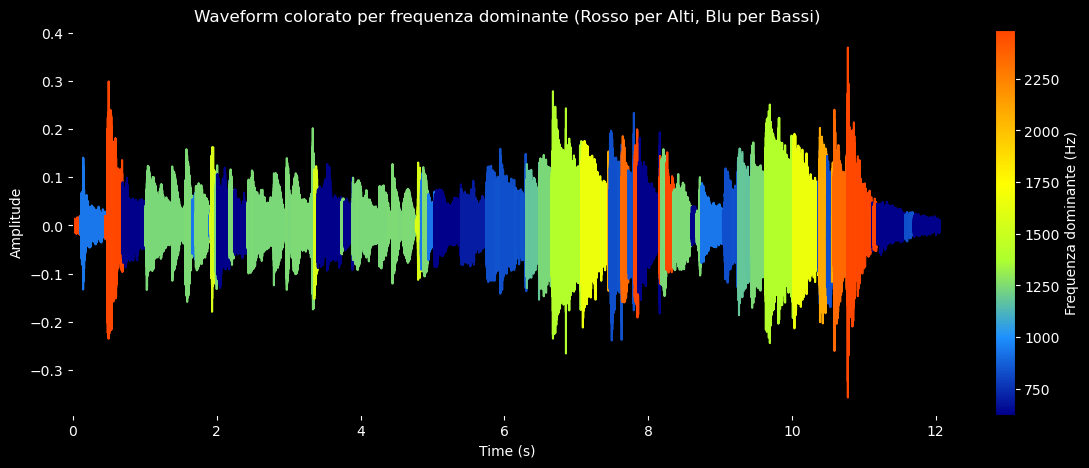

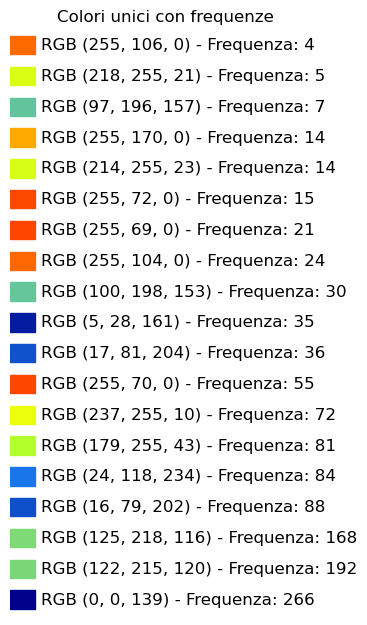

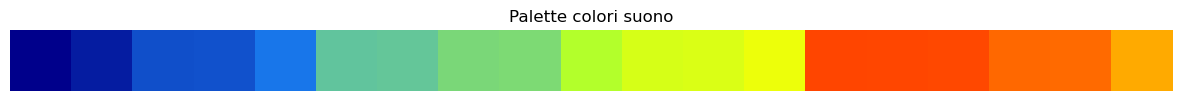

Analisi immagini: 100%|██████████| 1165/1165 [00:06<00:00, 168.63it/s]



--- Top 3 Immagini più Simili ---

🥇 Immagine 1: kazuo-shiraga_koushin-san-1980-1.jpg
🔗 Similarità media: 0.8116


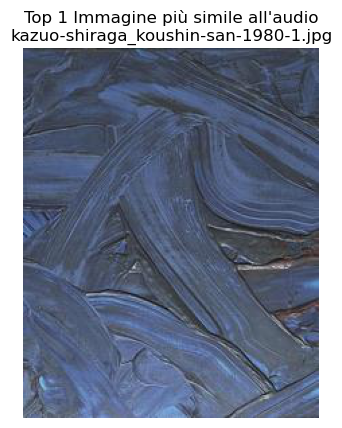

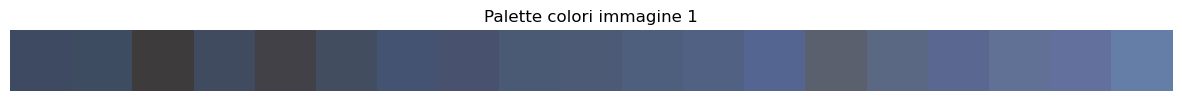


🥇 Immagine 2: genevieve-asse_blue-transparency-1971.jpg
🔗 Similarità media: 0.8107


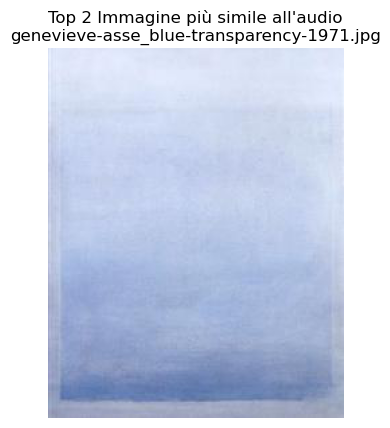

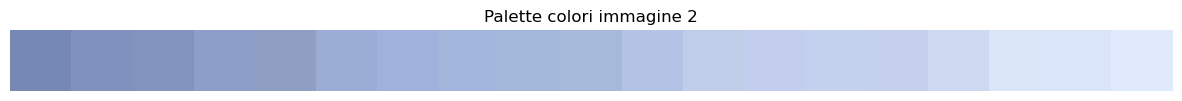


🥇 Immagine 3: luigi-guardigli_unknown-title-10.jpg
🔗 Similarità media: 0.8100


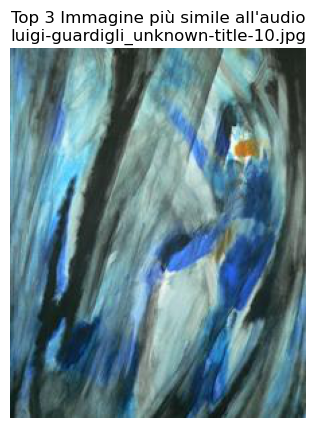

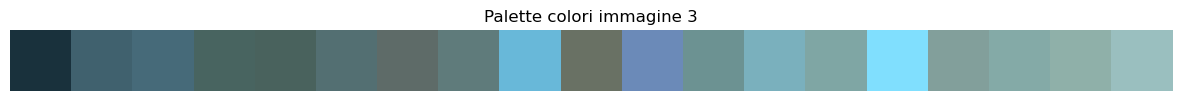


--- Analisi Completata ---


In [250]:
# --- Sezione per Eseguire il Codice ---
if __name__ == "__main__":
    # 1. Definisci il percorso del tuo file audio
    audio_file_to_analyze = r"C:\Users\edoar\Downloads\waveform\170106__klankbeeld__music-box-loop-05-fast.wav"

    # 2. Definisci il percorso della cartella che contiene le tue immagini
    image_dataset_folder = r"C:\Users\edoar\Desktop\images_small"

  
    # --- Esegui la funzione principale ---
    if os.path.exists(audio_file_to_analyze) and os.path.exists(image_dataset_folder):
        print("\n--- Avvio dell'analisi ---")
        best_matches = find_top_n_similar_images(
            audio_file_to_analyze,
            image_dataset_folder,
            n_colors=19,
            top_n=3
        )
        print("\n--- Analisi Completata ---")
    else:
        print("\nVerifica i percorsi dei file/cartelle. Impossibile avviare l'analisi.")